In [1]:
from ergochemics.mapping import get_reaction_center
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
import numpy as np
import polars as pl

def get_lhs_block_rc(am_smarts: str) -> list[int]:
    return get_reaction_center(am_smarts, mode="combined")[0]

In [2]:
study = "bottle25" # test

In [3]:
krs = pl.read_parquet("/home/stef/bottle/artifacts/known/known_reactions.parquet")
krs.head()

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""e908a824c912d1e39c46de92d1f738…","""**.NC(CCC(=O)NC(CS)C(=O)NCC(=O…","[""P10649"", ""P50472"", … ""Q08863""]","""3bbe8e6dca0da1c745e7678c8efebe…","[""RHEA:16438""]"
"""d86d99a8143d3be8fc861a5de5e625…","""*.*.*.*.*.*.*.*.*.*.CC(C)(COP(…","[""A0A0C6E0I7"", ""A0A0C6DWS6"", … ""Q0UK50""]","""e99fb0b75e799eba72aee21c1d04ee…","[""RHEA:51350""]"
"""2972b2db66715ba6f3d6aeaf07f31b…","""*.*.*.*.*.*.*.*.*NC(COP(=O)(O)…","[""G0REX6"", ""A0A482N9V7"", ""P0DO30""]","""5a7fffef224c65b7cd431ddc668eb2…","[""RHEA:64546""]"
"""572e4a84a946af07c9ab6fd1c0347b…","""*.*.*.*.*.*.*.*.*OP(=O)(O)OCC(…","[""A5UNX8"", ""Q57952"", … ""Q9V2B0""]","""c4c936d8d985a457a128601b8d2769…","[""RHEA:64377""]"
"""dfe7fc761de3c213bf2b18fae4f8a5…","""*.*.*.*.*.*.*.*.CC(C)CCCC(C)CC…","[""A5UNX8"", ""Q57952"", … ""Q9V2B0""]","""2e026380a550baa6b343604e6f5500…","[""RHEA:64369""]"


In [4]:
prs = pl.read_parquet(
    f"/home/stef/quest_data/bottle/results/{study}/predicted_reactions.parquet"
)
prs.head()

id,smarts,am_smarts,dxgb_label,rxn_sims,analogue_ids,rules
str,str,str,i32,list[f32],list[str],list[str]
"""Rf69ed2c3bad59b65f6f324fd36fb6…","""C[S+](CCC(N)C(=O)O)CC1OC(n2cnc…","""[CH3:1][S+:2]([CH2:3][CH2:4][C…",1,"[0.775672, 0.681005, … 0.652791]","[""1b0b2d567845cf2501ecca594b3ad73eee3861c7"", ""8e5206f209407d73ea31658451f5ffbd3df3202f"", … ""92ebcf5c9a1e75af5653ea48d89a6b14c7775112""]","[""mechinferred_dt_13_rules:1623""]"
"""Rc4541a603abeff0f750bc5f87a3a4…","""CC(CC(=O)O)C(=O)C(=O)O>>CC(C)C…","""[CH3:1][CH:2]([CH2:3][C:4](=[O…",1,"[0.466667, 0.466667, … 0.466667]","[""bb665ed7295cb9ecfc8920e5ccdca8364accbf87"", ""9c93783d22cdb98f5ca6134a9f20dadf32d07221"", … ""110f81a3d56023cd40721ba8582d2f7e3daccb64""]","[""mechinferred_dt_13_rules:3604""]"
"""Ra13283a4c98a0017d01d5b73a8eaa…","""CC(C)C(=O)C(=O)O>>CC1(C)C(=O)C…","""[CH3:1][CH:2]([CH3:3])[C:6](=[…",1,"[0.316228, 0.316228]","[""b5d9bdaa57b5aa799ea99d09b51ccbdb72fdb4fe"", ""b5d9bdaa57b5aa799ea99d09b51ccbdb72fdb4fe""]","[""mechinferred_dt_04_rules:4453""]"
"""Rc7f0cf64fcb6a67f1a319ed5124d3…","""O.CC1(C)C(=O)C1=O>>CC(C)(C=O)C…","""[OH2:8].[CH3:1][C:2]1([CH3:3])…",0,"[0.447214, 0.447214]","[""361dbf24883ee250caa57153b2b950560e464bbb"", ""361dbf24883ee250caa57153b2b950560e464bbb""]","[""mechinferred_dt_04_rules:9227""]"
"""R6dac6e1290d0ab683d2f07e26de84…","""CC(C)(C=O)C(=O)O.NC(=O)C1=CN(C…","""[CH3:1][C:2]([CH3:3])([CH:4]=[…",1,"[0.921053, 0.921053, … 0.857215]","[""f0c782f3f155879a265726490d27099e40d2ea65"", ""f0c782f3f155879a265726490d27099e40d2ea65"", … ""c9558d540f22683412fd5ee870dc1522c697b9bd""]","[""mechinformed_rules:351""]"


In [5]:
paths = pl.read_parquet(
    f"/home/stef/quest_data/bottle/results/{study}/found_paths.parquet"
)
paths.head()

id,starters,targets,reactions,dg_opt,dg_err,starter_ids,target_ids,mdf,mean_max_rxn_sim,mean_mean_rxn_sim,min_max_rxn_sim,min_mean_rxn_sim,feasibility_frac
str,list[str],list[str],list[str],list[f32],list[f32],list[str],list[str],f32,f32,f32,f32,f32,f32
"""Pfd4b5342ca2370367dad058c61477…","[""ketoglutarate""]","[""3hpa""]","[""Rf69ed2c3bad59b65f6f324fd36fb644c85c8bd21e41954e7ba875610f34aa5f8"", ""Rc4541a603abeff0f750bc5f87a3a4bb4d4bed21b45a9e7c31b8151f99fe6b4de"", … ""R6dac6e1290d0ab683d2f07e26de8489c0360f3b54c83a31b08a60a69bbc99c7d""]",null,null,"[""Ce264bf1bbd482e436995855afdf2170ce7229f1d""]","[""Ca44a84be6f833fe631009a55d05e4807de958fe0""]",null,0.585366,0.555031,0.316228,0.316228,0.8
"""P83941f3ecf2f21f3a835cf814bf24…","[""ketoglutarate""]","[""3hpa""]","[""Rf69ed2c3bad59b65f6f324fd36fb644c85c8bd21e41954e7ba875610f34aa5f8"", ""Rc4541a603abeff0f750bc5f87a3a4bb4d4bed21b45a9e7c31b8151f99fe6b4de"", … ""R78e8cb7b0c1c6ff56c0f4cc1d0155418598562c82c6a159b0eb4798054aefcfb""]",null,null,"[""Ce264bf1bbd482e436995855afdf2170ce7229f1d""]","[""Ca44a84be6f833fe631009a55d05e4807de958fe0""]",null,0.501156,0.478224,0.316228,0.316228,0.6
"""P7fc528c58b89f6dfdd5615cf945a1…","[""ketoglutarate""]","[""dmhb""]","[""Rf69ed2c3bad59b65f6f324fd36fb644c85c8bd21e41954e7ba875610f34aa5f8"", ""Rc4541a603abeff0f750bc5f87a3a4bb4d4bed21b45a9e7c31b8151f99fe6b4de"", … ""R3258aef59dfd631844d137779f54c4c2bcbde79355c73cb6a3ab9de43a87707d""]",null,null,"[""Ce264bf1bbd482e436995855afdf2170ce7229f1d""]","[""Cc2274a1b151121868789bd03eb37b9c4065ef3d1""]",null,0.799637,0.771741,0.466667,0.466667,0.6
"""P897045fb6ecc75d636e0fbd64b2f8…","[""ketoglutarate""]","[""3hpa""]","[""Ra13002f8cca9d2907a31543ec661e22ad1e168f050a9b158c1a597575aca4e01"", ""Re0d2372881104d93733f68ede539ecc49cf2ef4706112b0279a886a56d550bdc"", … ""R6dac6e1290d0ab683d2f07e26de8489c0360f3b54c83a31b08a60a69bbc99c7d""]",null,null,"[""Ce264bf1bbd482e436995855afdf2170ce7229f1d""]","[""Ca44a84be6f833fe631009a55d05e4807de958fe0""]",null,0.61911,0.601089,0.316228,0.316228,0.8
"""Pa17f2ba53edb5a410f9be56e85222…","[""ketoglutarate""]","[""3hpa""]","[""Ra13002f8cca9d2907a31543ec661e22ad1e168f050a9b158c1a597575aca4e01"", ""Re0d2372881104d93733f68ede539ecc49cf2ef4706112b0279a886a56d550bdc"", … ""R78e8cb7b0c1c6ff56c0f4cc1d0155418598562c82c6a159b0eb4798054aefcfb""]",null,null,"[""Ce264bf1bbd482e436995855afdf2170ce7229f1d""]","[""Ca44a84be6f833fe631009a55d05e4807de958fe0""]",null,0.534899,0.524282,0.316228,0.316228,0.6


Reaction 1: R8867459e4201138c2d6ff7989ea3f1b352f599fb4f9035702a8dd66abeb5984e, Max sim: 1.0


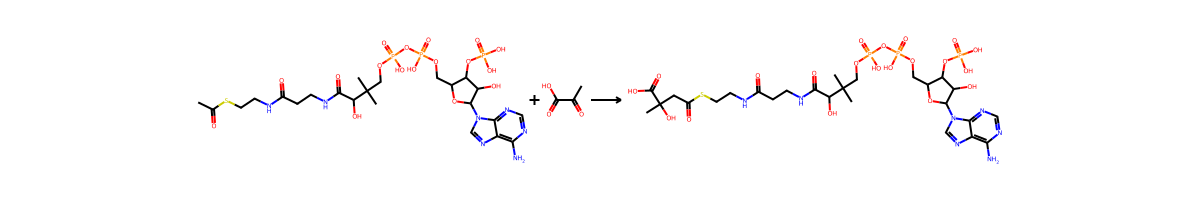

Reaction 2: Rd29576fcff659fb0791106671c246753c21a555237b64a22e1dd347bfbae0d7c, Max sim: 1.0


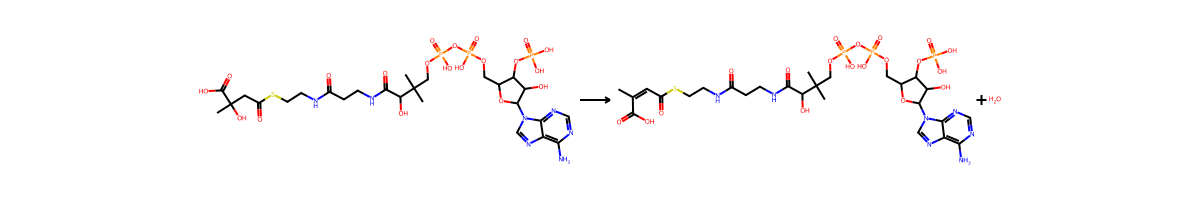

Reaction 3: Rb2e87d63a7b89e4967d8980454761ffe22c9a06e5d955494b81619937cde476e, Max sim: 0.772926926612854


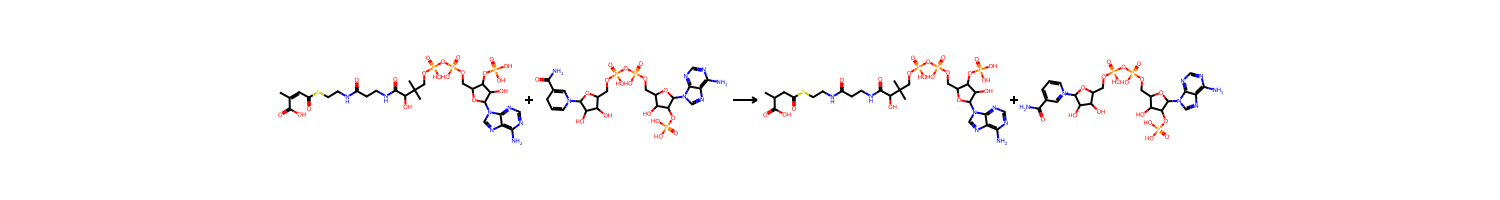

Reaction 4: Rc20e20166a08e82f66e48b57ac011293f68b0edec9cdd32b3df0fd29a7672c2d, Max sim: 0.6880624890327454


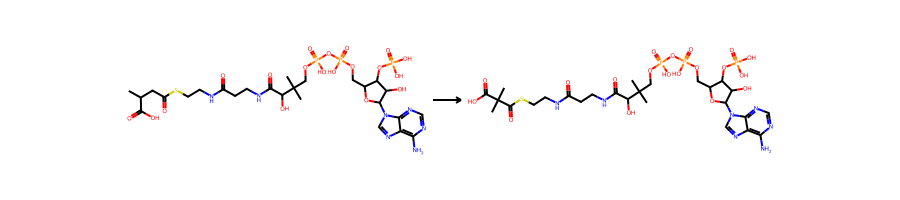

Reaction 5: Rbe75dabb6cd717370c8d27a731caa6e87968e34358e1894cc82711b9f1299f9a, Max sim: 0.8000442981719971


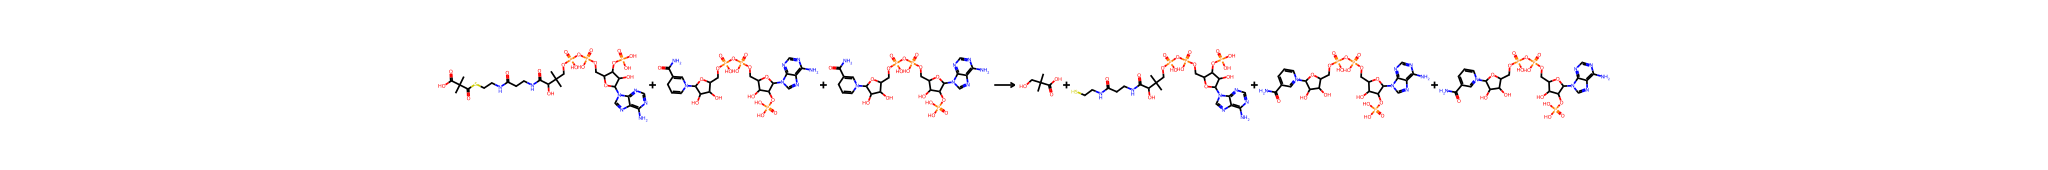

In [20]:
pid = 'P80a2b1'
rids = paths.filter(pl.col("id").str.starts_with(pid))["reactions"].to_list()[0]
path = prs.filter(pl.col("id").is_in(rids)).sort(
    pl.col("id").replace({id: idx for idx, id in enumerate(rids)}),
).with_columns(
    pl.col("rxn_sims").list.max().alias("max_sim")
)
for i, row in enumerate(path.iter_rows(named=True)):
    print(f"Reaction {i+1}: {row['id']}, Max sim: {row['max_sim']}")
    display(
        SVG(
            draw_reaction(row['smarts'])
        )
    )